In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
path  = "C:/Users/User/Downloads/7113.KL(2017-2022).csv"
df = pd.read_csv(path, sep=",")
df.head()
df['Date'] =  pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df = df.drop('Date',axis=1)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-27,1.073333,1.103333,1.071666,1.075000,0.912288,27835200.0
2017-10-30,1.080000,1.091666,1.073333,1.075000,0.912288,7378200.0
2017-10-31,1.083333,1.083333,1.053333,1.066666,0.905216,9283200.0
2017-11-01,1.066666,1.083333,1.065000,1.066666,0.905216,5490600.0
2017-11-02,1.066666,1.080000,1.063333,1.066666,0.905216,10039800.0


In [3]:
df.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)

In [5]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

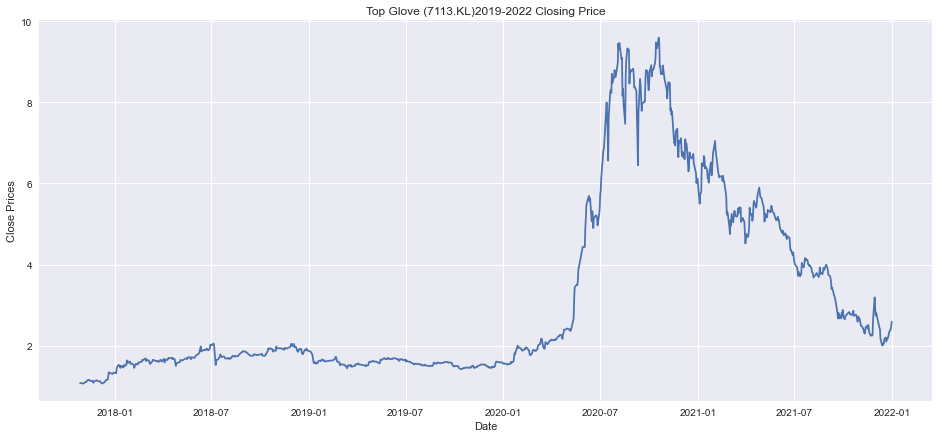

In [6]:
plt.figure(figsize=(16,7))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df.Close)
plt.title('Top Glove (7113.KL)2019-2022 Closing Price')
plt.show()

In [7]:
def adfuller_test(stocks):
    result=adfuller(stocks)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

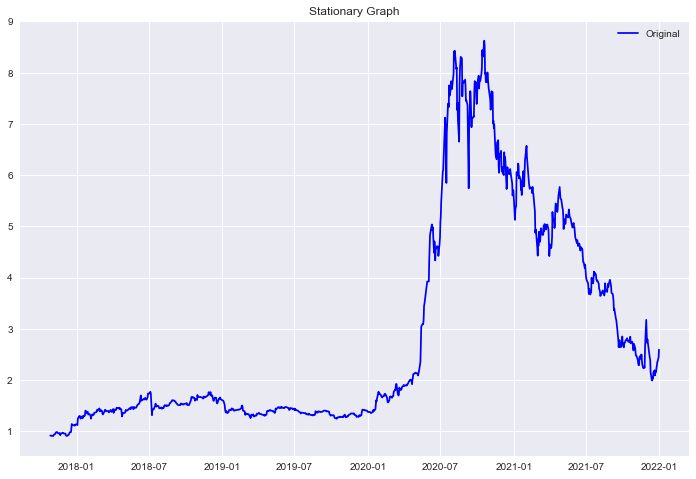

Results of Dickey-Fuller Test:
p-value = 0.5898. The series is likely non-stationary.
Test Statistic                   -1.384358
p-value                           0.589752
#Lags Used                       19.000000
Number of Observations Used    1008.000000
Critical Value (1%)              -3.436854
Critical Value (5%)              -2.864412
Critical Value (10%)             -2.568299
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    #mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Stationary Graph')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(df['Adj Close'])

In [9]:
adfuller_test(df['Adj Close'])

ADF Test Statistic : -1.3843583981782095
p-value : 0.5897515040115703
#Lags Used : 19
Number of Observations : 1008


In [10]:
first_diff =df['Adj Close']-df['Adj Close'].shift(1)
first_diff = first_diff.dropna(inplace = False)

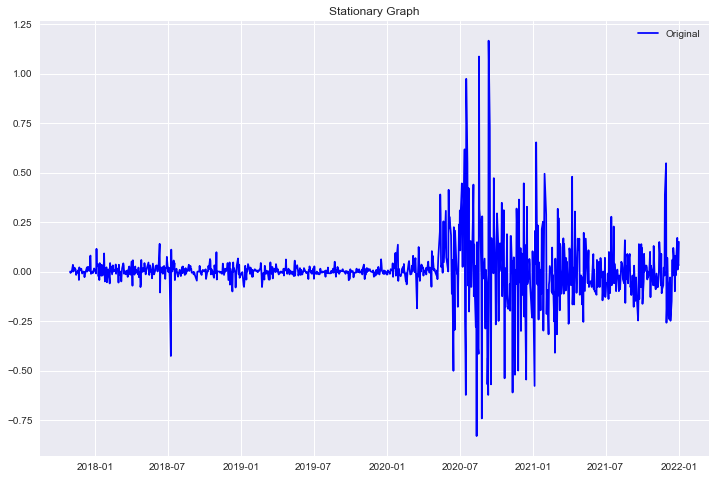

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.582493e+00
p-value                        7.453808e-09
#Lags Used                     1.800000e+01
Number of Observations Used    1.008000e+03
Critical Value (1%)           -3.436854e+00
Critical Value (5%)           -2.864412e+00
Critical Value (10%)          -2.568299e+00
dtype: float64


In [11]:
test_stationarity(first_diff, window = 12)

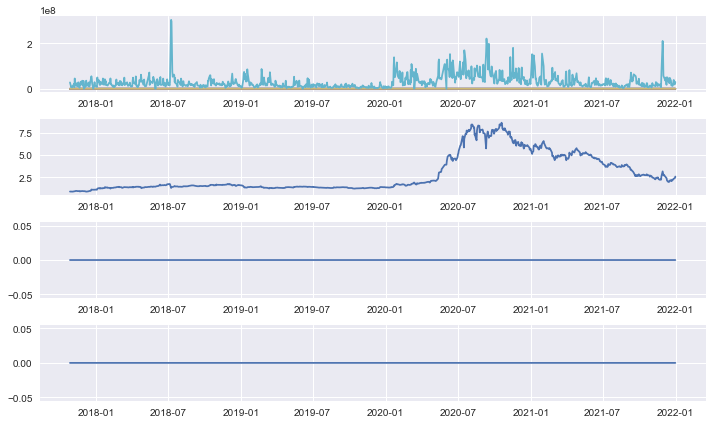

In [12]:
# Checking Trend and Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(df['Adj Close'], freq=1)
trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid
plt.subplot(411) 
plt.plot(df, label='Original') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.tight_layout() 
plt.show()

In [13]:
model_train=df.iloc[:int(df.shape[0]*0.75)]
valid=df.iloc[int(df.shape[0]*0.75):]
y_pred=valid.copy()

In [14]:
model_scores_r2=[]
model_scores_mse=[]
model_scores_rmse=[]
model_scores_mae=[]
model_scores_rmsle=[]
model_arima= auto_arima(model_train["Adj Close"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
              suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Adj Close"])

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-844.496, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-848.033, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-858.369, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-858.884, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-846.625, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-850.949, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-858.721, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-857.164, Time=0.57 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-859.058, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-860.751, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-861.511, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-866.689, Time=0.95 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-860.840, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-859.475, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-859.458, Time=0.92 sec

Best mode

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True)

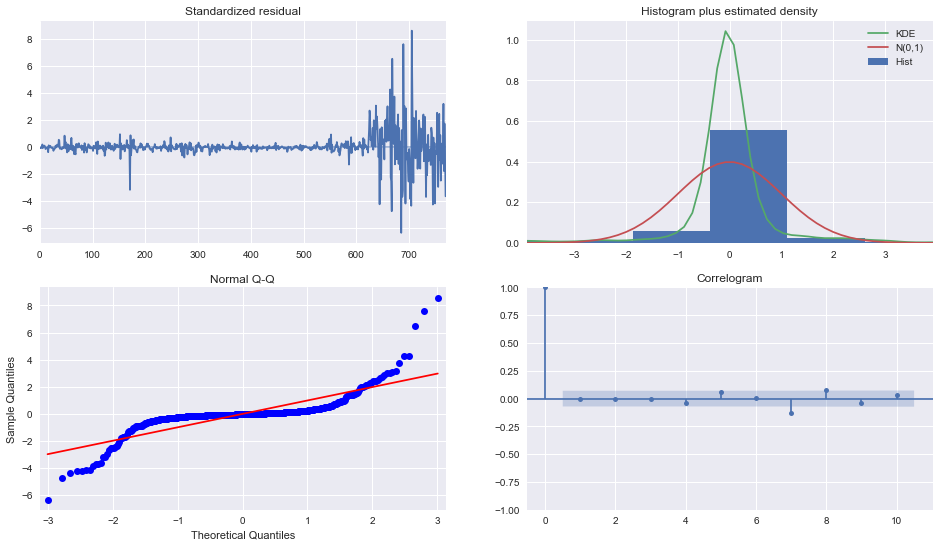

In [24]:
model_arima.plot_diagnostics(figsize=(16,9))
plt.show()

In [15]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  771
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 440.345
Date:                Wed, 03 May 2023   AIC                           -866.689
Time:                        12:25:12   BIC                           -834.165
Sample:                             0   HQIC                          -854.172
                                - 771                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0021      0.002      1.379      0.168      -0.001       0.005
ar.L1          1.4915      0.029     52.218      0.000       1.435       1.547
ar.L2         -0.7584      0.032    -23.465      0.0

In [16]:
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error,mean_squared_log_error

prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima
r2_arima= r2_score(y_pred["Adj Close"],y_pred["ARIMA Model Prediction"])
mse_arima= mean_squared_error(y_pred["Adj Close"],y_pred["ARIMA Model Prediction"])
rmse_arima=np.sqrt(mean_squared_error(y_pred["Adj Close"],y_pred["ARIMA Model Prediction"]))
mae_arima=mean_absolute_error(y_pred["Adj Close"],y_pred["ARIMA Model Prediction"])
rmsle_arima = np.sqrt(mean_squared_log_error(y_pred["Adj Close"],y_pred["ARIMA Model Prediction"]))
model_scores_r2.append(r2_arima)
model_scores_mse.append(mse_arima)
model_scores_rmse.append(rmse_arima)
model_scores_mae.append(mae_arima)
model_scores_rmsle.append(rmsle_arima)
print("R Square Score ARIMA: ",r2_arima)
print("Mean Square Error ARIMA: ",mse_arima)
print("Root Mean Square Error ARIMA: ",rmse_arima)
print("Mean Absoulute Error ARIMA: ",mae_arima)
print("Root Mean Squared Logarithmic Error ARIMA: ", rmsle_arima)

R Square Score ARIMA:  -5.554685090810985
Mean Square Error ARIMA:  10.357212370004065
Root Mean Square Error ARIMA:  3.2182623215027184
Mean Absoulute Error ARIMA:  2.6749127975745486
Root Mean Squared Logarithmic Error ARIMA:  0.5514745989331498


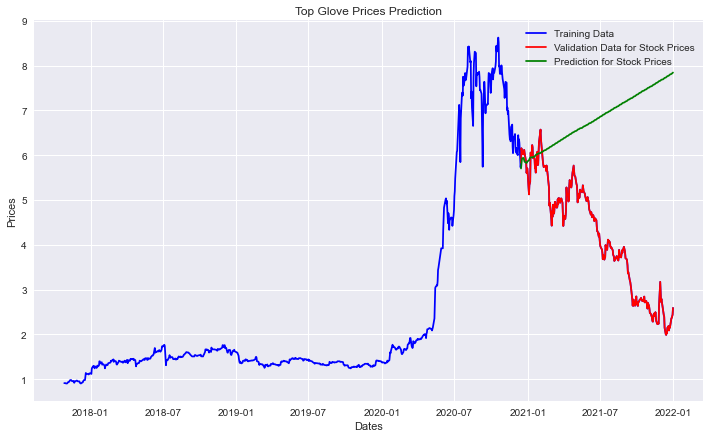

In [17]:
plt.figure(figsize=(12,7))
plt.plot(df['Adj Close'], 'green', color='blue', label='Training Data')
plt.plot(valid.index,valid["Adj Close"],'red',label="Validation Data for Stock Prices")
plt.plot(valid.index, y_pred["ARIMA Model Prediction"],'green',label="Prediction for Stock Prices")
plt.title('Top Glove Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

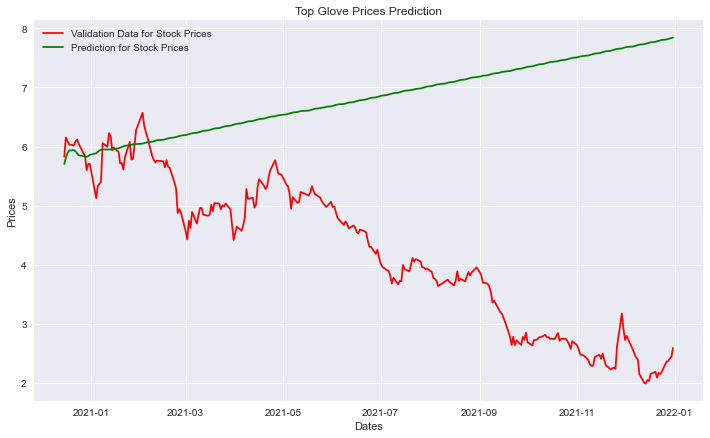

In [18]:
plt.figure(figsize=(12,7))
plt.plot(valid.index,valid["Adj Close"],'red',label="Validation Data for Stock Prices")
plt.plot(valid.index, y_pred["ARIMA Model Prediction"],'green',label="Prediction for Stock Prices")
plt.title('Top Glove Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

In [19]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [20]:
from sklearn.metrics import mean_absolute_percentage_error
error = mean_squared_error(y_pred["Adj Close"],y_pred["ARIMA Model Prediction"])
error2 = smape_kun(y_pred["Adj Close"],y_pred["ARIMA Model Prediction"])
print('Symmetric mean absolute percentage error: %.3f' % error2)


print('=============================================')
print('              Diagnostic Check')
print('=============================================')
mse = mean_squared_error(y_pred["Adj Close"],y_pred["ARIMA Model Prediction"])
print('MSE: '+str(mse))
mae = mean_absolute_error(y_pred["Adj Close"],y_pred["ARIMA Model Prediction"])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_pred["Adj Close"],y_pred["ARIMA Model Prediction"]))
print('RMSE: '+str(rmse))
mape_value = mean_absolute_percentage_error(y_pred["Adj Close"],y_pred["ARIMA Model Prediction"])
print('MAPE:', mape_value)
MSE_error = mean_squared_error(y_pred["Adj Close"],y_pred["ARIMA Model Prediction"])
print('=============================================')
print('Testing Mean Squared Error: %.3f' % error)
print('=============================================')

Symmetric mean absolute percentage error: 50.854
              Diagnostic Check
MSE: 10.357212370004065
MAE: 2.6749127975745486
RMSE: 3.2182623215027184
MAPE: 0.8731278184173812
Testing Mean Squared Error: 10.357
